In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

用pd.read_csv读取数据集，将第一列作为title并使用“；”分隔csv文本。使用sample随机抽取数据赋值给data，其中frac=1表示抽取100%的数据。

输出为打乱后数据的前几行

In [30]:
""" 读取数据集并打乱并切分为训练集和测试集 """
# 1.data
# 1.1 read data
data_path='.\\winequality-white.csv'
data=pd.read_csv(data_path,sep=';')

# 1.2 data analysis
# 1.2.1 check dataset
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


没有missing value

Histogram of raw data


D:\Anaconda\envs\machine\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\envs\machine\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\envs\machine\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

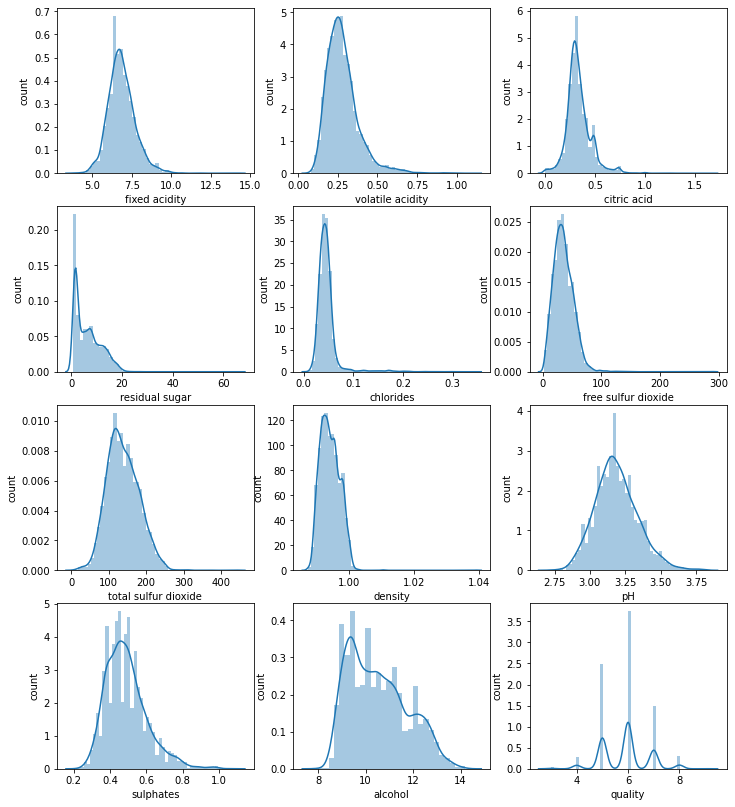

In [31]:
# 1.2.2 直方图
print('Histogram of raw data')
fig= plt.figure(figsize=[12,14])
for i in range(data.shape[1]):  # 列数循环
    # 排成4*3的子图，逐次填充绘制每一个子图
    plt.subplot(4,3,i+1)
    sns.distplot(data.iloc[:,i])
    plt.ylabel('count')

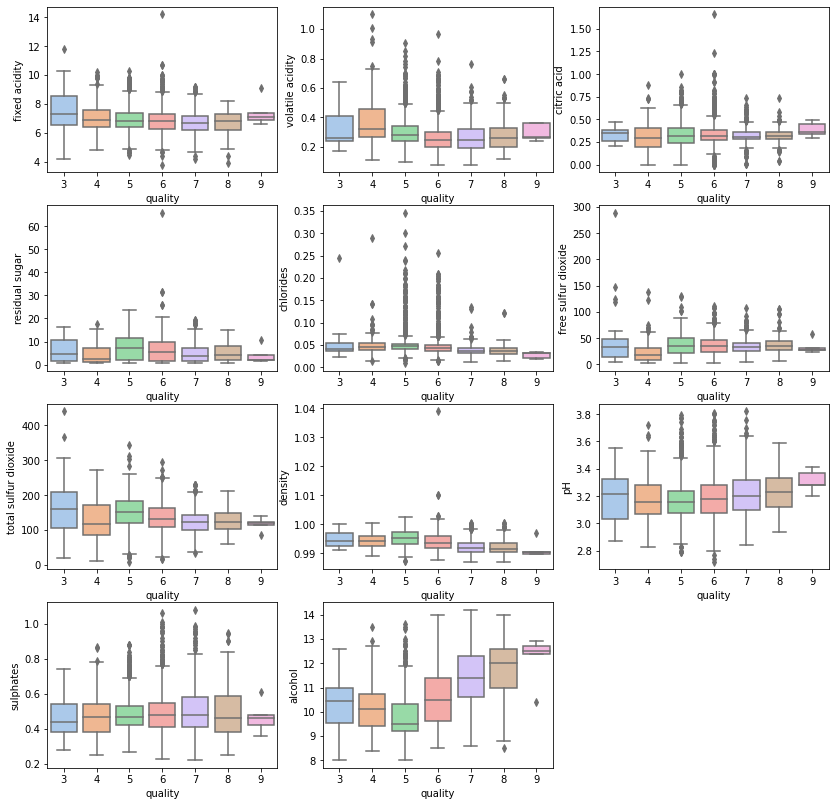

In [32]:
# 1.2.3箱型图
fig= plt.figure(figsize=[14,14])
for i in range(data.shape[1]-1):
    plt.subplot(4,3,i+1)
    # 设置横纵坐标和显示颜色
    sns.boxplot(x=data['quality'],y=data.iloc[:,i],palette='pastel')

<AxesSubplot:>

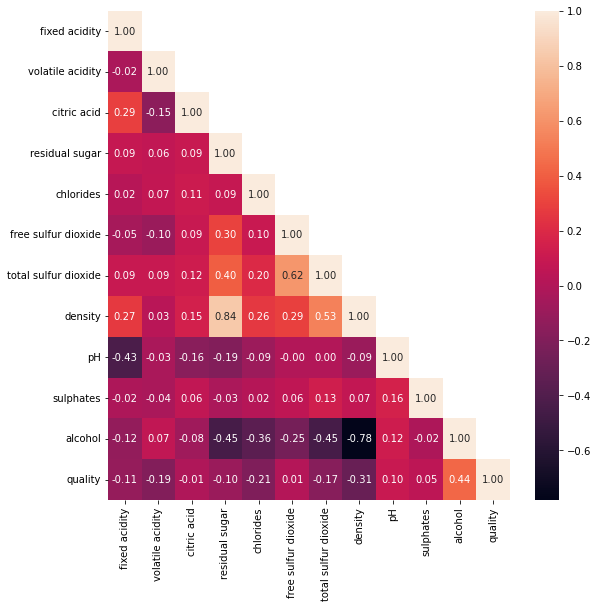

In [33]:
# 1.2.4 corralation
data_cor=data.corr() # 获取相关系数
# 转换为上三角矩阵
data_cor_up=np.triu(data_cor,1)
# data_cor_up

fig,ax=plt.subplots(figsize=(9,9))
# 写完报告删掉这行，annot:显示数字，fmt显示两位小数,mask用上三角矩阵覆盖,center：colorbar在0分界
sns.heatmap(data_cor,mask=data_cor_up,annot=True,fmt='.2f')

（描述并修改成正式文本）从箱型图可以看到噪音点的情况，特别是。。。还是挺多的，因此要进行噪音处理（我在瞎比比，我也不知道是不是这样说）
分析可以参考 https://www.enjoyalgorithms.com/blog/wine-quality-prediction 

In [34]:
# 1.3 data processing
# 1.3.1 

# numpy format
data_np=np.array(data)

# (1) split x and y
xs, ys = np.split(data_np,[11], axis=1 )
ys = ys.reshape(-1)

print(ys)

[6. 6. 6. ... 6. 7. 6.]


In [35]:
# (2)saparate training and testing data and random
# train: 80%; test:20%
from sklearn.model_selection import train_test_split

xs_train, xs_test, ys_train, ys_test = train_test_split(xs, ys, test_size = 0.2,random_state=0)

print('training set shape:\t', xs_train.shape)
print('test set shape:\t\t', xs_test.shape)

training set shape:	 (3918, 11)
test set shape:		 (980, 11)


对数值类型的特征做归一化可以将所有的特征都统一到一个大致相同的数值区间内。
使用z-score标准化数据集，经过处理的trian data符合标准正态分布

In [36]:
# (3) normalization with z-score
mu = np.mean(xs_train, axis=0)
sigma = np.std(xs_train, axis=0)

xs_train = (xs_train - mu)/sigma
xs_test = (xs_test - mu)/sigma

如上文分析
这里使用sklearn的PCA函数进行处理。先降维后升维
https://blog.csdn.net/qq_37334135/article/details/87026462
https://www.cnblogs.com/volcao/p/9261228.html

In [37]:
# 1.3.2 noisy处理（PCA)
# !!!!!加不加test data????

from sklearn.decomposition import PCA

# (1) 找到pca关系
pca=PCA()
pca.fit(xs_train)
# pca.fit(xs)

pca_rate=np.cumsum(pca.explained_variance_ratio_)
print(np.around(pca_rate,3))
# 前10个feature解释了99.9%的因变量

[0.296 0.437 0.549 0.644 0.731 0.814 0.881 0.935 0.973 0.999 1.   ]


TypeError: 'str' object is not callable

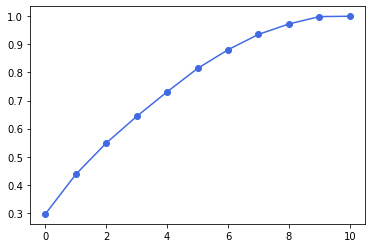

In [43]:
plt.plot(pca_rate,'royalblue')
plt.plot(pca_rate,'o',color='royalblue')
plt.xlabel('feature')
plt.ylabel('explained ratio')

前10个feature解释了99.9%的因变量.
降到10维

In [44]:
# (2) 降维再升维
pca=PCA(10)
xs_trans=pca.fit_transform(xs_train)
xs_inverse=pca.inverse_transform(xs_trans)

print('降维后:\t', xs_trans.shape)
print('升维后:\t', xs_inverse.shape)

降维后:	 (3918, 10)
升维后:	 (3918, 11)


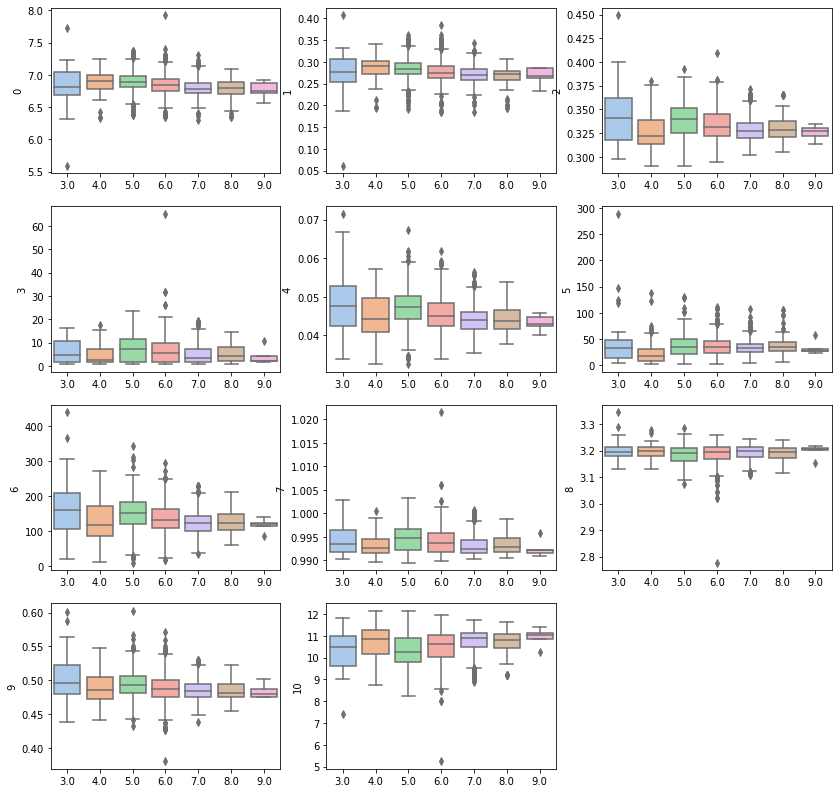

In [52]:
# (2) 降维再升维
# 这里花了全数据集转化后
pca=PCA(3)
xs_trans = pca.fit_transform(xs)
xs_pca = pca.inverse_transform(xs_trans)

# 1.3.3 处理后的图
xs_pca_pd=pd.DataFrame(xs_pca)

fig= plt.figure(figsize=[14,14])
for i in range(xs_inverse.shape[1]):
    plt.subplot(4,3,i+1)
    # 设置横纵坐标和显示颜色
    sns.boxplot(x=ys,y=xs_pca_pd[i],palette='pastel')
    plt.xlabel=('quality')
    plt.ylabel=(data.columns.values[i])
    # 咱也不知道为啥画不上

# 降噪了！！！

In [ ]:
# # 1.3 random data
# data=data.sample(frac=1)
# print(data.head())

使用numpy将数据集变为array，竖向切分数组赋值给examples(xs)和target value(ys)，并将ys转置。
输出为转制后的ys数据集

横向切分打乱后的数据集为测试集和训练集，分别为20%和80%。
输出为测试集和训练集的样本数和feature数

In [6]:
# # 1.5 saparate training and testing data
# # train: 80%; test:20%
# train_number = len(xs) * 80 // 100
# xs_train, xs_test = np.split(xs, [train_number], axis=0)
# ys_train, ys_test = np.split(ys, [train_number], axis=0)

# print('training set shape:\t', xs_train.shape)
# print('test set shape:\t\t', xs_test.shape)

# # from sklearn.cross_validation import train_test_split



training set shape:	 (3918, 11)
test set shape:		 (980, 11)


对数值类型的特征做归一化可以将所有的特征都统一到一个大致相同的数值区间内。
使用z-score标准化数据集，经过处理的trian data符合标准正态分布

In [7]:
# # 1.5 normalization with z-score
# mu = np.mean(xs_train, axis=0)
# sigma = np.std(xs_train, axis=0)

# xs_train = (xs_train - mu)/sigma
# xs_test = (xs_test - mu)/sigma